### Remove scroll from figures

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {?
    return false;
}

<IPython.core.display.Javascript object>

## Extend the size of the Window

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Load Modules

In [3]:
import netCDF4 as nc
import glob
import numpy as np
import pandas as pd
import xarray as xr
import itertools

from idtxl.data import Data
from idtxl.bivariate_te import BivariateTE
from idtxl.visualise_graph import plot_network

import matplotlib.pyplot as plt
import matplotlib as mpl

## Read CMIP Data into xarray

In [4]:
# Define paths
histDataPath = '../../data/CMIP/hist-sol/'
solDataPath = '../../data/CMIP/hist-sol/'

In [5]:
# Find files
histFiles = glob.glob(histDataPath + '*.nc')
solFiles = glob.glob(solDataPath + '*.nc')


### Create variables for hist-sol run

In [34]:

hist_sol = None
for file in solFiles:
    if hist_sol is None:
        hist_sol = xr.open_dataset(file)
    else:
        hist_sol = hist_sol.combine_first(xr.open_dataset(file))

# Convert to seasonal average
month_length = hist_sol.time.dt.days_in_month
hist_sol = ((hist_sol['tas'] * month_length).resample(time='QS-DEC').sum() / 
          month_length.resample(time='QS-DEC').sum()).to_dataset(name = 'tas')

# Reset index to middle of the season
# hist_sol['time'] = hist_sol['time'] + pd.to_timedelta((month_length.resample(time='QS-DEC').sum()/2).data, 'd')
hist_sol['time'] = hist_sol['time'] + pd.to_timedelta(45, 'd')
# Select only whole seasons
hist_sol = hist_sol.sel(time=slice('1976-01-01', '2014-11-01'))
hist_sol

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 144, time: 156)
Coordinates:
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
    height   float64 2.0
  * time     (time) object 1976-01-15 00:00:00 ... 2014-10-16 00:00:00
Data variables:
    tas      (time, lat, lon) float64 238.3 238.3 238.3 ... 245.8 245.8 245.8

### Create variables for hist run

In [35]:
hist_all = None
for file in histFiles:
    if hist_all is None:
        hist_all = xr.open_dataset(file)
    else:
        hist_all = hist_all.combine_first(xr.open_dataset(file))

# Convert to seasonal average
month_length = hist_all.time.dt.days_in_month
hist_all = ((hist_all['tas'] * month_length).resample(time='QS-DEC').sum() / 
          month_length.resample(time='QS-DEC').sum()).to_dataset(name = 'tas')

# Reset index to middle of the season
# hist_all['time'] = hist_all['time'] + pd.to_timedelta((month_length.resample(time='QS-DEC').sum()/2).data, 'd')
hist_all['time'] = hist_all['time'] + pd.to_timedelta(45, 'd')
# Select only whole seasons
hist_all = hist_all.sel(time=slice('1976-01-01', '2014-11-01'))
hist_all

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 144, time: 156)
Coordinates:
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
    height   float64 2.0
  * time     (time) object 1976-01-15 00:00:00 ... 2014-10-16 00:00:00
Data variables:
    tas      (time, lat, lon) float64 238.3 238.3 238.3 ... 245.8 245.8 245.8

## Read Sunspot Data and create xarray

In [36]:
# Define path
snDataPath = '../../data/Sunspot Number/SN_m_tot_V2.0.csv'

# Read cr monthly average file with custom column names
colnames=['year', 'month', 'FracYear', 'SN', 'crsd', 'NObs', 'prov'] 
sn = pd.read_csv(snDataPath, delimiter=';', names=colnames)
sn['day'] = 15
sn['time'] = pd.to_datetime(sn.loc[:,['year', 'month', 'day']])
sn = sn.set_index('time', drop=True)
sn = sn.to_xarray().convert_calendar("noleap")

# Convert to seasonal average
month_length = sn.time.dt.days_in_month
sn = ((sn['SN'] * month_length).resample(time='QS-DEC').sum() / 
          month_length.resample(time='QS-DEC').sum()).to_dataset(name = 'sn')

# sn['SNav'] = sn['SN'].rolling(time=12, min_periods=1, center=True).mean()
# sn = sn.sel(time=slice(np.min(hist_sol.time.data)-pd.Timedelta(0, 'd'), np.max(hist_sol.time.data)))

# Reset index to middle of the season
sn['time'] = sn['time'] + pd.to_timedelta(45, 'd')
# Select only whole seasons
sn = sn.sel(time=slice('1976-01-01', '2014-11-01'))

sn


<xarray.Dataset>
Dimensions:  (time: 156)
Coordinates:
  * time     (time) object 1976-01-15 00:00:00 ... 2014-10-16 00:00:00
Data variables:
    sn       (time) float64 10.09 25.65 14.93 19.32 ... 128.5 118.0 103.3 107.7

## Read Neutron Monitor Data and create xarray

In [37]:
# Define path
crDataPath = '../../data/Cosmic Rays/OULU_1964_04_01 _00_00_2020_10_26 _00_00.csv'

# Read cr monthly average file with custom column names\
cr = pd.read_csv(crDataPath)
cr['time'] = pd.to_datetime(cr['Timestamp']).dt.tz_localize(None)
cr = cr.set_index('time', drop=True)
cr = cr.to_xarray().convert_calendar("noleap")
# cr['crav'] = cr['CorrectedCountRate[cts/min]'].rolling(time=365, min_periods=1, center=True).mean()
# cr = cr.sel(time=slice(np.min(hist_sol.time.data)-pd.Timedelta(0, 'd'), np.max(hist_sol.time.data)))

# Convert to seasonal average
cr = cr['CorrectedCountRate[cts/min]'].resample(time='QS-DEC').mean().to_dataset(name = 'cr')

# Reset index to middle of the season
cr['time'] = cr['time'] + pd.to_timedelta(45, 'd')
# Select only whole seasons
cr = cr.sel(time=slice('1976-01-01', '2014-11-01'))

cr

<xarray.Dataset>
Dimensions:  (time: 156)
Coordinates:
  * time     (time) object 1976-01-15 00:00:00 ... 2014-10-16 00:00:00
Data variables:
    cr       (time) float64 6.421e+03 6.263e+03 ... 6.177e+03 6.157e+03

## Plot solar data

(-8746.0, 5398.0)

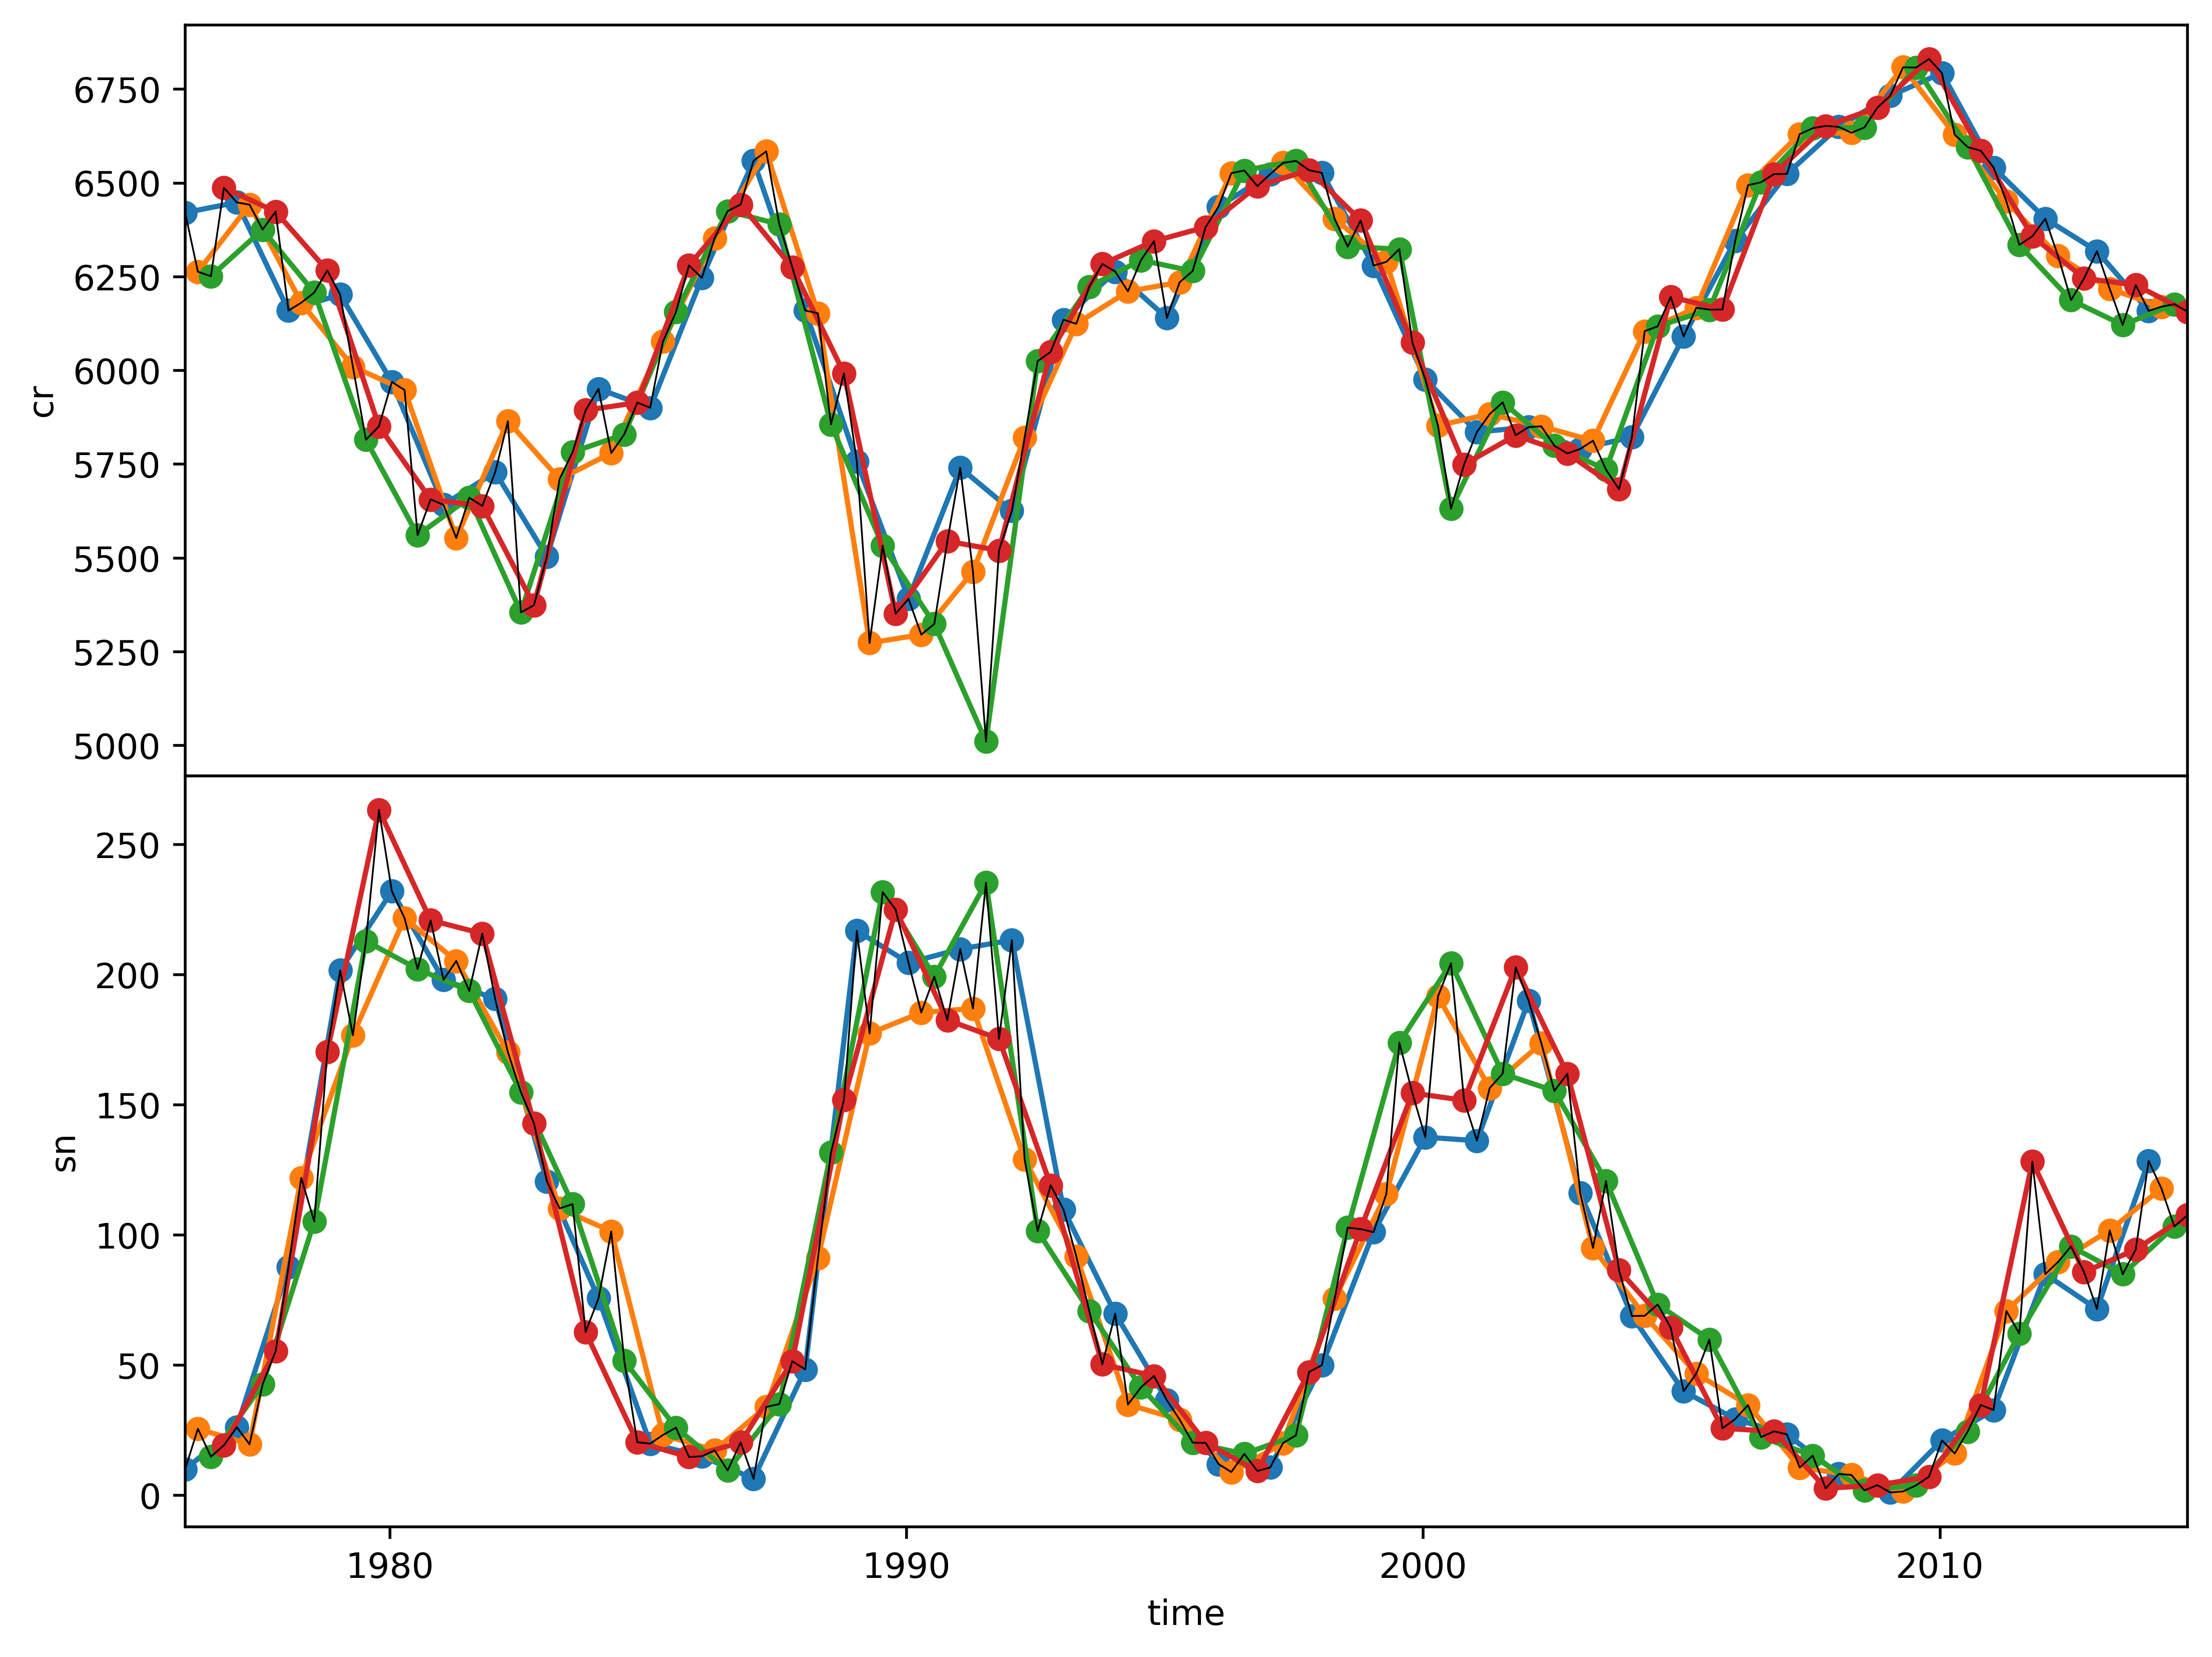

In [48]:
months = np.fromiter(hist_sol.groupby('time.month').groups.keys(), dtype=int)


fig = plt.figure(figsize=2*np.array([4, 3]), dpi=500)
gs0 = fig.add_gridspec(2, 1, wspace=0.15, hspace=0, left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(gs0[0, 0])
cr_slice = cr.groupby('time.month')
for month in months:  
    cr_slice[month]['cr'].plot(ax=ax, marker='o')

cr['cr'].plot(ax=ax, c='k', lw=0.5)
# sn['SNav'].plot(ax=ax, c='w', lw=3)
# sn['SNav'].plot(ax=ax, c='r', lw=1, ls='--')
ax.set_xlim([np.min(hist_sol.time.data), np.max(hist_sol.time.data)])


ax = fig.add_subplot(gs0[1, 0])
cr_slice = sn.groupby('time.month')
for month in months:  
    sn_slice[month]['sn'].plot(ax=ax, marker='o')

sn['sn'].plot(ax=ax, c='k', lw=0.5)
# sn['SNav'].plot(ax=ax, c='w', lw=3)
# sn['SNav'].plot(ax=ax, c='r', lw=1, ls='--')
ax.set_xlim([np.min(hist_sol.time.data), np.max(hist_sol.time.data)])

## Run Bivariate analysis

Adding data with properties: 2 processes, 39 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0]

Target: 0 - testing sources [1]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 11) maximum statistic, n_perm: 200
testing candidate: (0, 6) maximum statistic, n_perm: 200
testing candidate: (0, 17) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set current source: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 2

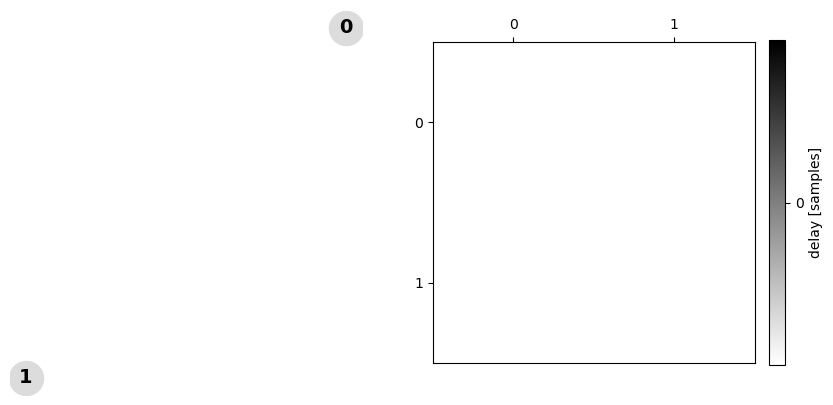

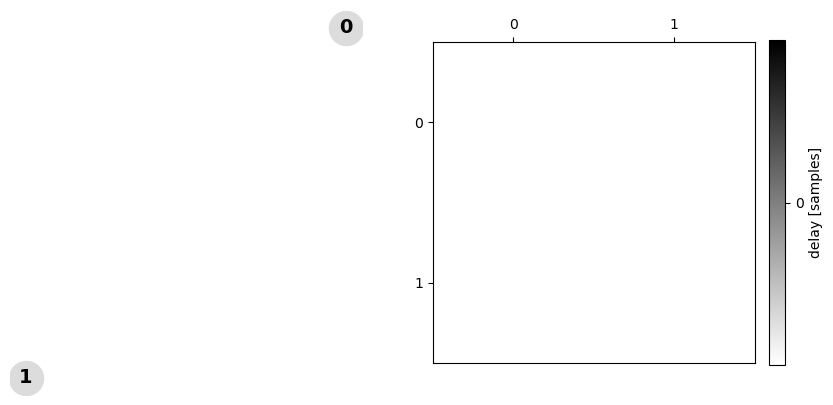

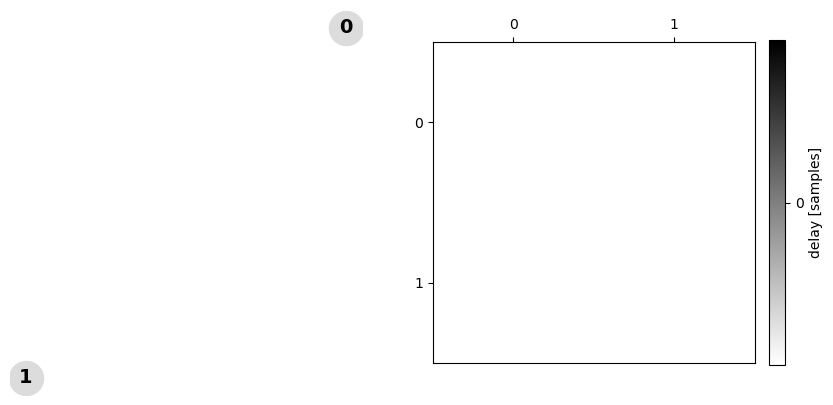

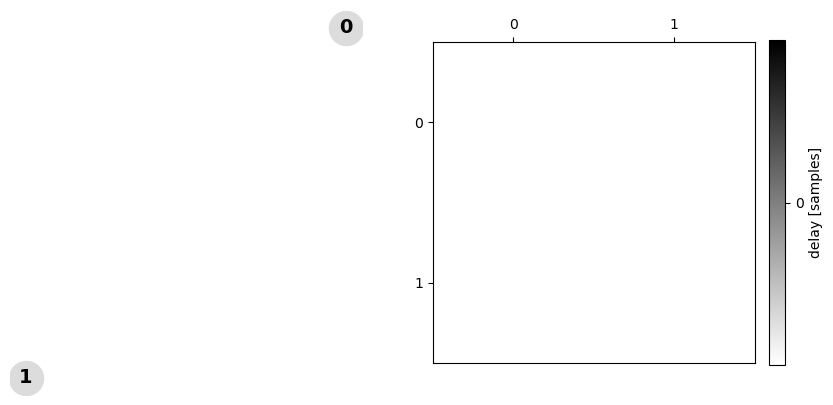

In [51]:
network_analysis = BivariateTE()
settings = {'cmi_estimator': 'JidtGaussianCMI',
            'max_lag': 24,
            'max_lag_sources': 24,
            'min_lag_sources': 1}

# settings = {'cmi_estimator': 'OpenCLKraskovCMI',
#             'max_lag': 24,
#             'max_lag_sources': 24,
#             'min_lag_sources': 1}

settings = {'cmi_estimator': 'JidtKraskovCMI',
            'max_lag': 24,
            'max_lag_sources': 24,
            'min_lag_sources': 1}


sn_slice = sn.groupby('time.month')
cr_slice = cr.groupby('time.month')
for month in months:
    dataList = [cr_slice[month]['cr'].data, sn_slice[month]['sn']]
    idt_data = Data(np.column_stack((itertools.zip_longest(*dataList, fillvalue=0))), dim_order='ps')
    results = network_analysis.analyse_network(settings=settings, data=idt_data, sources=[1], targets=[0])

    results.print_edge_list(weights='max_te_lag', fdr=False)
    plot_network(results=results, weights='max_te_lag', fdr=False)

            

## Select a random month, latitude, and longitude and plot

(-8746.0, 5398.0)

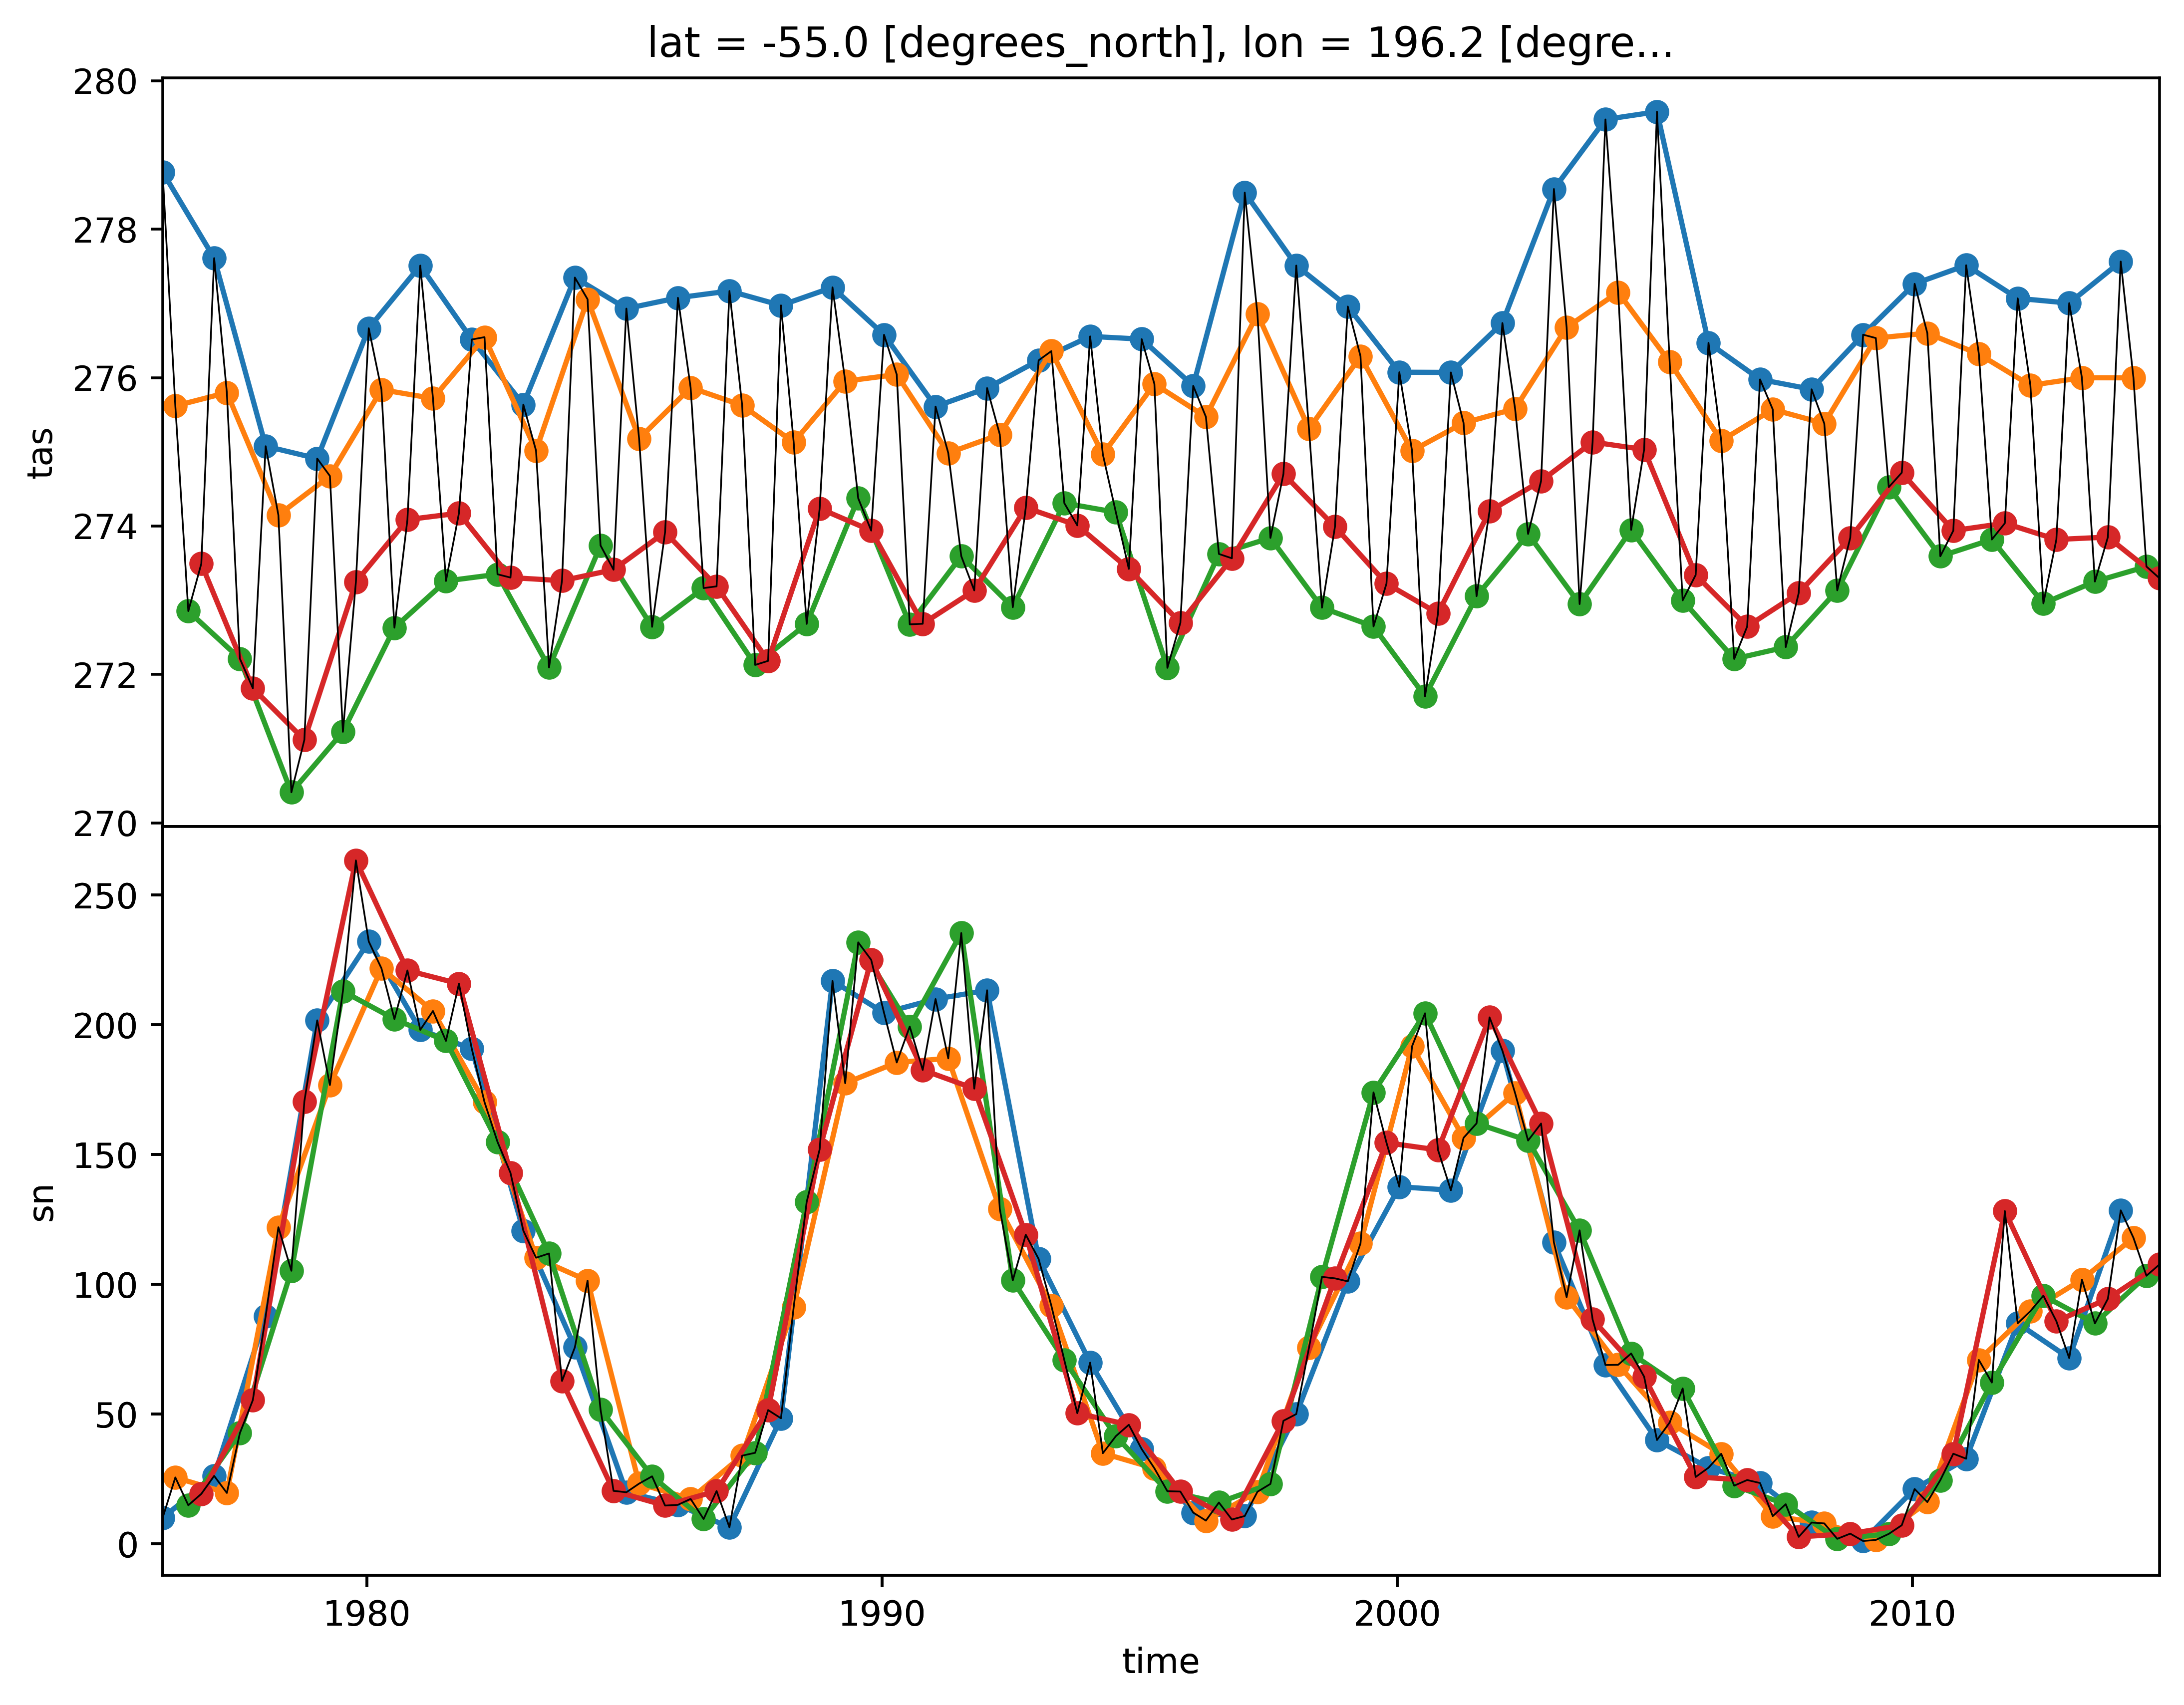

In [45]:
months = np.fromiter(hist_sol.groupby('time.month').groups.keys(), dtype=int)
month = np.random.choice(months)
lat = hist_sol.lat.data[np.random.randint(0, hist_sol.lat.shape[0]-1)]
lon = hist_sol.lon.data[np.random.randint(0, hist_sol.lon.shape[0]-1)]


fig = plt.figure(figsize=2*np.array([4, 3]), dpi=500)
gs0 = fig.add_gridspec(2, 1, wspace=0.15, hspace=0, left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(gs0[0, 0])

sol_slice = hist_sol.groupby('lat')[lat].groupby('lon')[lon].groupby('time.month')
all_slice = hist_all.groupby('lat')[lat].groupby('lon')[lon].groupby('time.month')
for month in months:
    all_slice[month]['tas'].plot(ax=ax, marker='o')

hist_all.groupby('lat')[lat].groupby('lon')[lon]['tas'].plot(ax=ax, c='k', lw=0.5)
ax.set_xlim([np.min(hist_sol.time.data), np.max(hist_sol.time.data)])


ax = fig.add_subplot(gs0[1, 0])
sn_slice = sn.groupby('time.month')
for month in months:  
    sn_slice[month]['sn'].plot(ax=ax, marker='o')

sn['sn'].plot(ax=ax, c='k', lw=0.5)
# sn['SNav'].plot(ax=ax, c='w', lw=3)
# sn['SNav'].plot(ax=ax, c='r', lw=1, ls='--')
ax.set_xlim([np.min(hist_sol.time.data), np.max(hist_sol.time.data)])


ax = fig.add_subplot(gs0[1, 0])
cr_slice = sn.groupby('time.month')
for month in months:  
    sn_slice[month]['sn'].plot(ax=ax, marker='o')

sn['sn'].plot(ax=ax, c='k', lw=0.5)
# sn['SNav'].plot(ax=ax, c='w', lw=3)
# sn['SNav'].plot(ax=ax, c='r', lw=1, ls='--')
ax.set_xlim([np.min(hist_sol.time.data), np.max(hist_sol.time.data)])

## Run Bivariate analysis

Adding data with properties: 2 processes, 39 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0]

Target: 0 - testing sources [1]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24)]
testing candidate: (0, 20) 
maximum statistic, n_perm: 200
 -- not significant

No informative sources in the target's past - adding target sample with lag 1.

---------------------------- (2) include source candidates
candidate set current source: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24)]
testing candidate: (1, 11) maximum statistic, n_perm: 200
 -- not significant



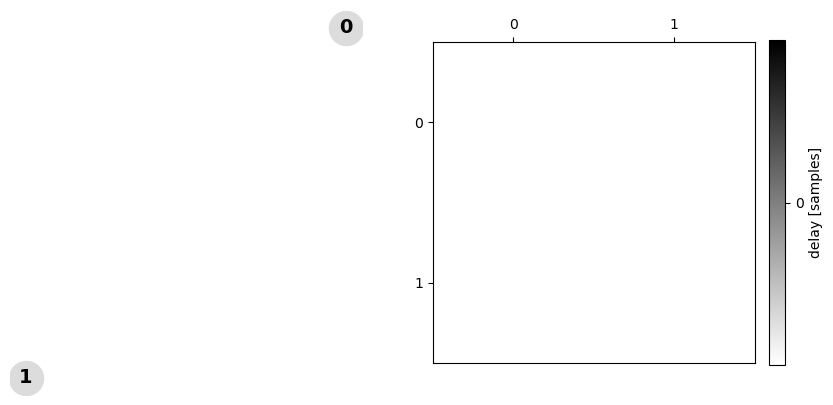

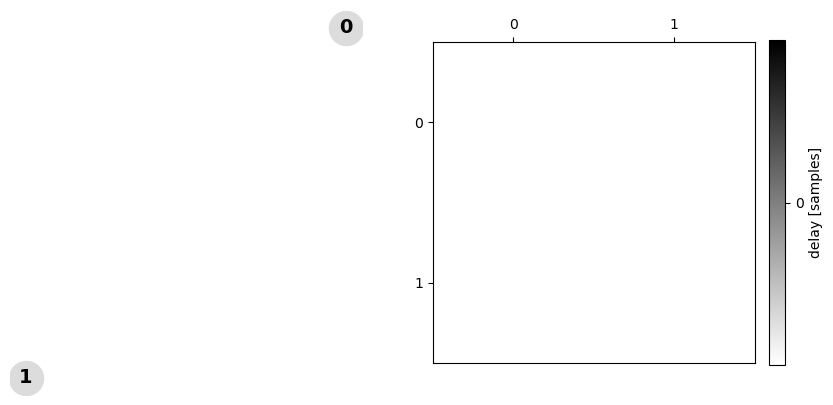

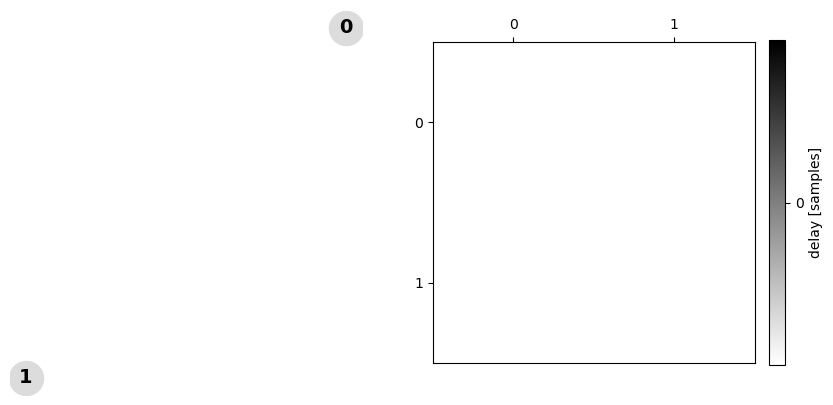

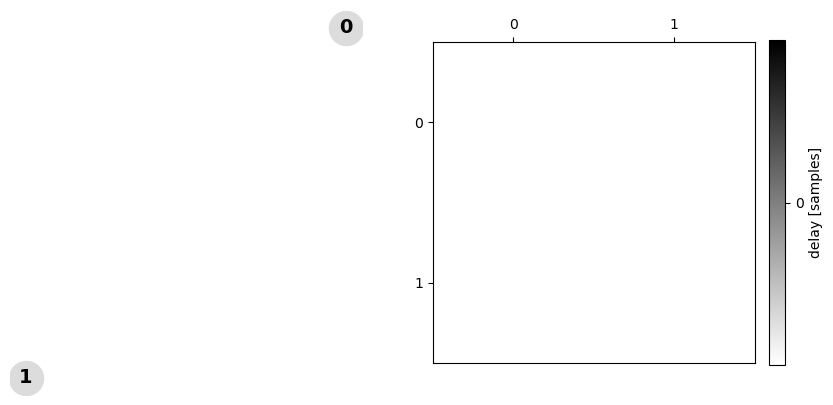

In [47]:
network_analysis = BivariateTE()
# settings = {'cmi_estimator': 'JidtGaussianCMI',
#             'max_lag': 24,
#             'max_lag_sources': 24,
#             'min_lag_sources': 1}

settings = {'cmi_estimator': 'OpenCLKraskovCMI',
            'max_lag': 24,
            'max_lag_sources': 24,
            'min_lag_sources': 1}



sol_slice = hist_sol.groupby('lat')[lat].groupby('lon')[lon].groupby('time.month')
all_slice = hist_all.groupby('lat')[lat].groupby('lon')[lon].groupby('time.month')
sn_slice = sn.groupby('time.month')
for month in months:
    dataList = [all_slice[month]['tas'].data, sn_slice[month]['sn']]
    idt_data = Data(np.column_stack((itertools.zip_longest(*dataList, fillvalue=0))), dim_order='ps')
    results = network_analysis.analyse_network(settings=settings, data=idt_data, sources=[1], targets=[0])

    results.print_edge_list(weights='max_te_lag', fdr=False)
    plot_network(results=results, weights='max_te_lag', fdr=False)

            

In [ ]:
import idtxl.estimators_opencl
help(idtxl.estimators_opencl)

Help on module idtxl.estimators_opencl in idtxl:

NAME
    idtxl.estimators_opencl

CLASSES
    idtxl.estimator.Estimator(builtins.object)
        OpenCLKraskov
            OpenCLKraskovCMI
            OpenCLKraskovMI
    
    class OpenCLKraskov(idtxl.estimator.Estimator)
     |  OpenCLKraskov(settings=None)
     |  
     |  Abstract class for implementation of OpenCL estimators.
     |  
     |  Abstract class for implementation of OpenCL estimators, child classes
     |  implement estimators for mutual information (MI) and conditional mutual
     |  information (CMI) using the Kraskov-Grassberger-Stoegbauer estimator for
     |  continuous data.
     |  
     |  References:
     |  
     |  - Kraskov, A., Stoegbauer, H., & Grassberger, P. (2004). Estimating mutual
     |    information. Phys Rev E, 69(6), 066138.
     |  - Lizier, Joseph T., Mikhail Prokopenko, and Albert Y. Zomaya. (2012).
     |    Local measures of information storage in complex distributed computation.
     |   

## Select a random month, latitude, and longitude and plot

(-8744.5, 5459.5)

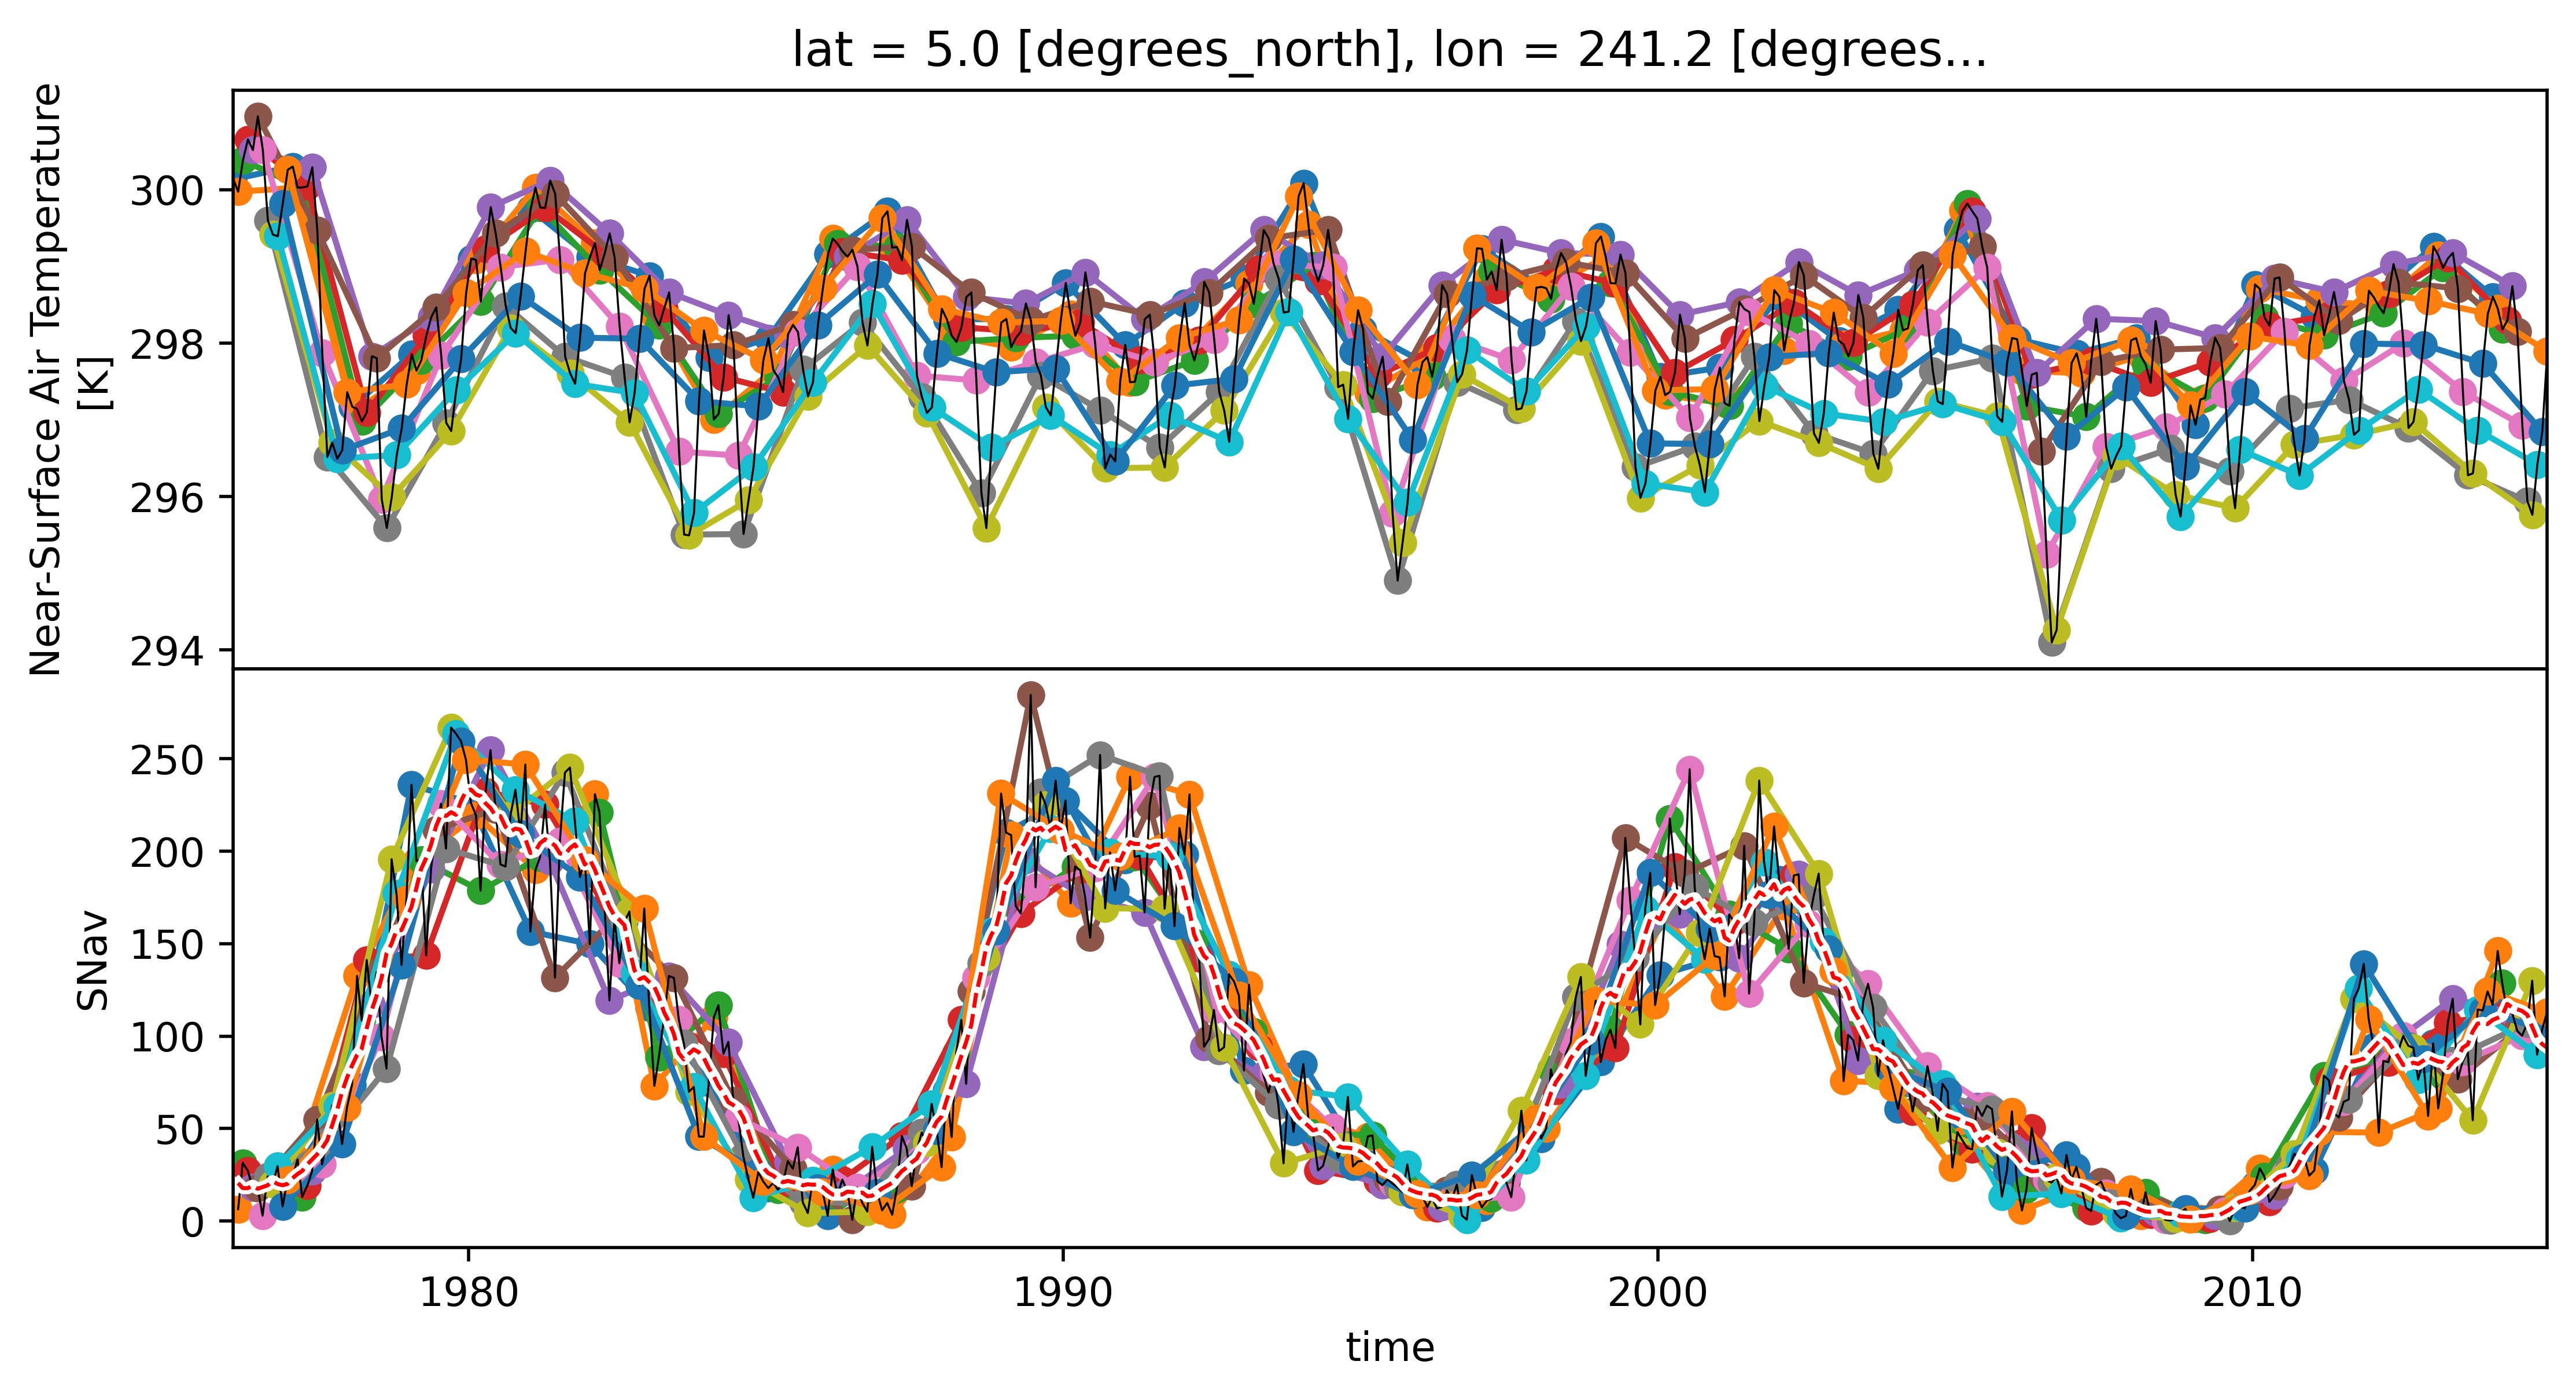

In [ ]:
month = np.random.randint(1,12)
lat = hist_sol.lat.data[np.random.randint(0, hist_sol.lat.shape[0]-1)]
lon = hist_sol.lon.data[np.random.randint(0, hist_sol.lon.shape[0]-1)]


fig = plt.figure(figsize=2*np.array([4, 2]), dpi=500)
gs0 = fig.add_gridspec(2, 1, wspace=0.15, hspace=0, left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(gs0[0, 0])

sol_slice = hist_sol.groupby('lat')[lat].groupby('lon')[lon].groupby('time.month')
all_slice = hist_all.groupby('lat')[lat].groupby('lon')[lon].groupby('time.month')
for month in range(1,13):
    all_slice[month]['tas'].plot(ax=ax, marker='o')

hist_all.groupby('lat')[lat].groupby('lon')[lon]['tas'].plot(ax=ax, c='k', lw=0.5)
ax.set_xlim([np.min(hist_sol.time.data), np.max(hist_sol.time.data)])


ax = fig.add_subplot(gs0[1, 0])
cr_slice = cr.groupby('time.month')
for month in range(1,13):  
    cr_slice[month]['SN'].plot(ax=ax, marker='o')

cr['SN'].plot(ax=ax, c='k', lw=0.5)
cr['crav'].plot(ax=ax, c='w', lw=3)
cr['crav'].plot(ax=ax, c='r', lw=1, ls='--')
ax.set_xlim([np.min(hist_sol.time.data), np.max(hist_sol.time.data)])

## Run Bivariate analysis

Adding data with properties: 2 processes, 39 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0]

Target: 0 - testing sources [1]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24)]
testing candidate: (0, 4) 
maximum statistic, n_perm: 200
 -- not significant

No informative sources in the target's past - adding target sample with lag 1.

---------------------------- (2) include source candidates
candidate set current source: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24)]
testing candidate: (1, 19) maximum statistic, n_perm: 200
testing candidate: (1,

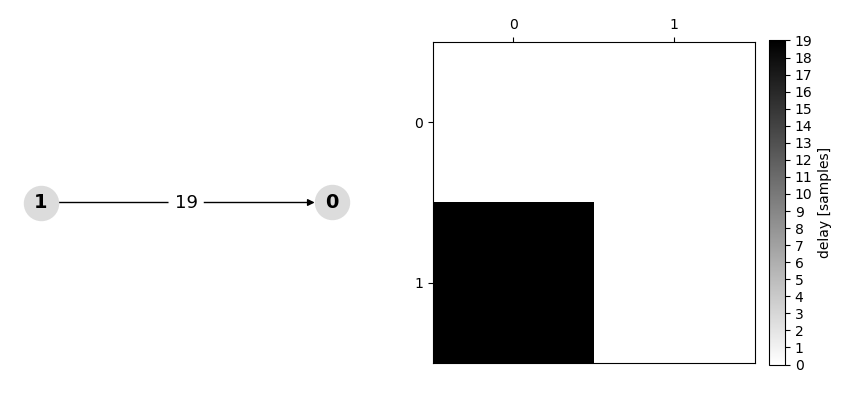

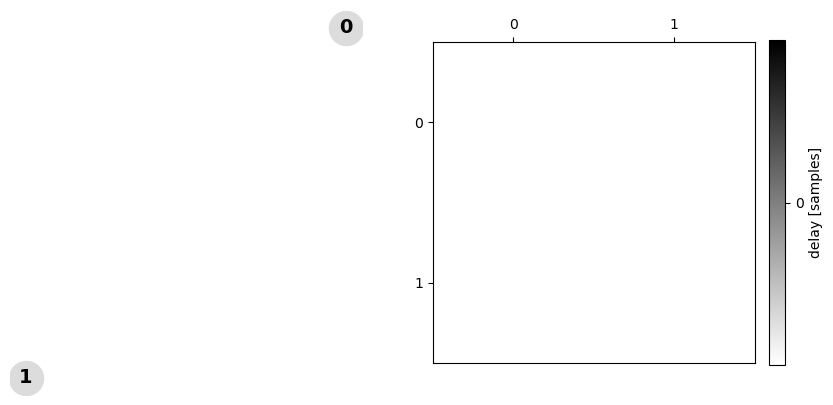

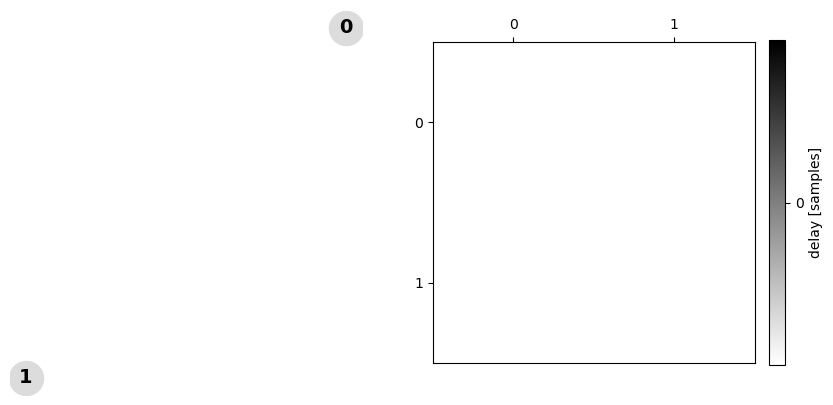

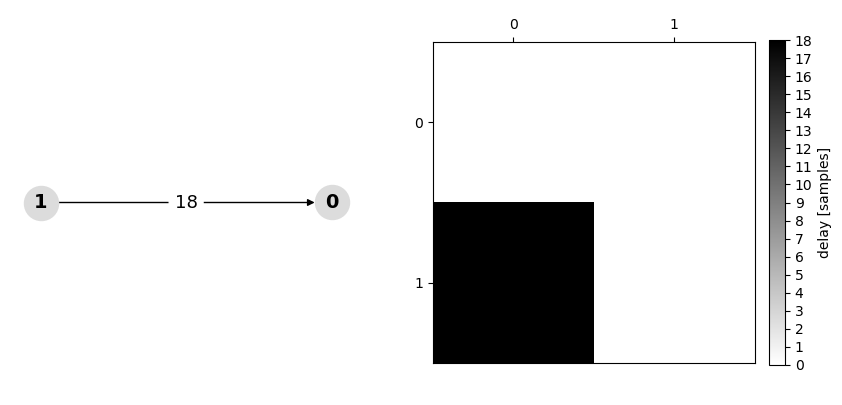

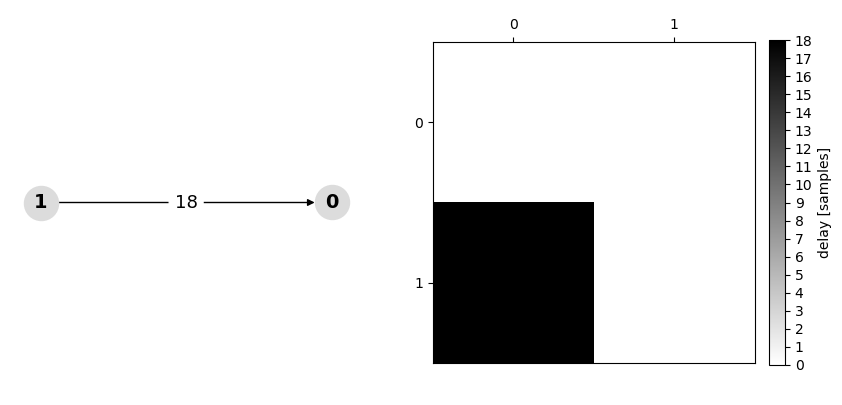

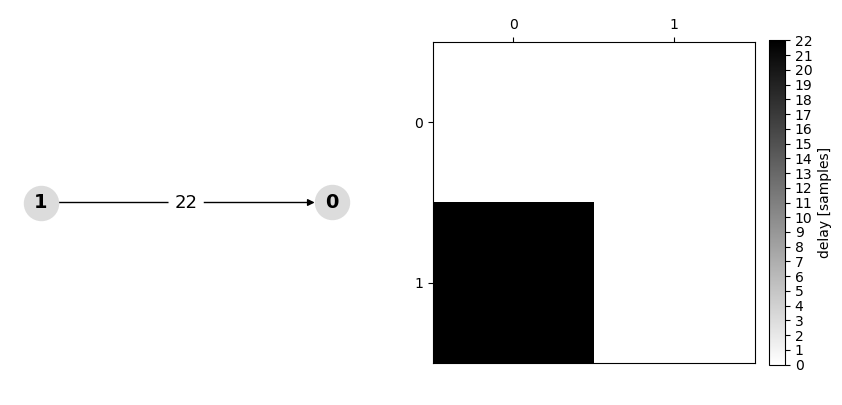

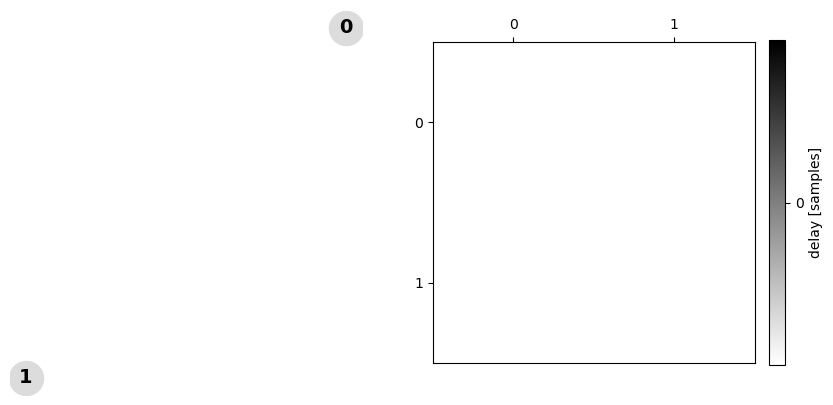

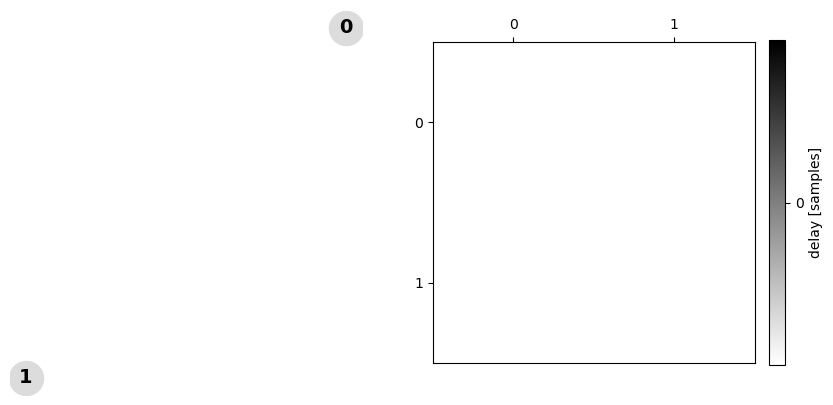

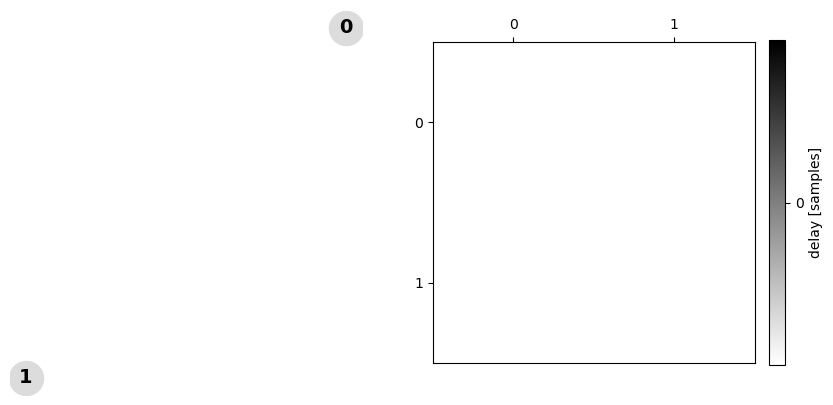

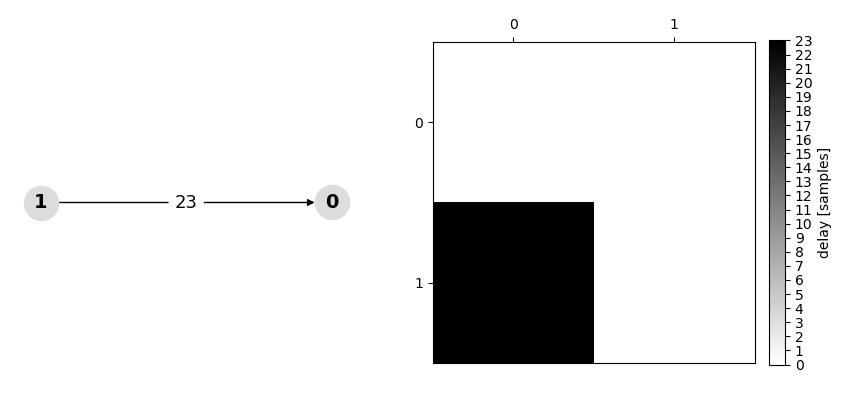

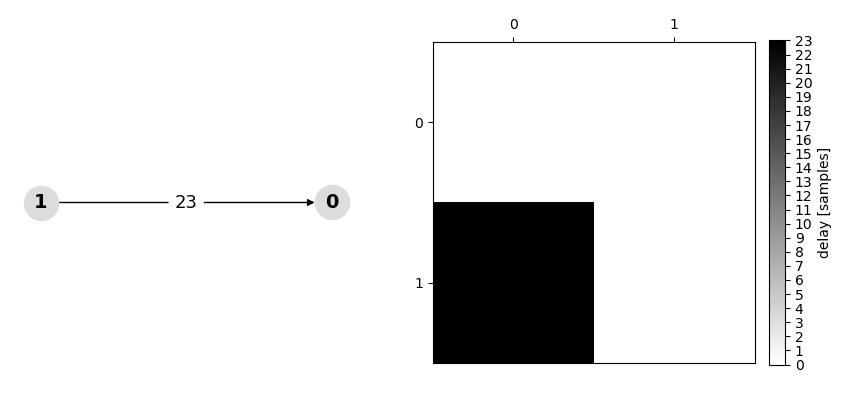

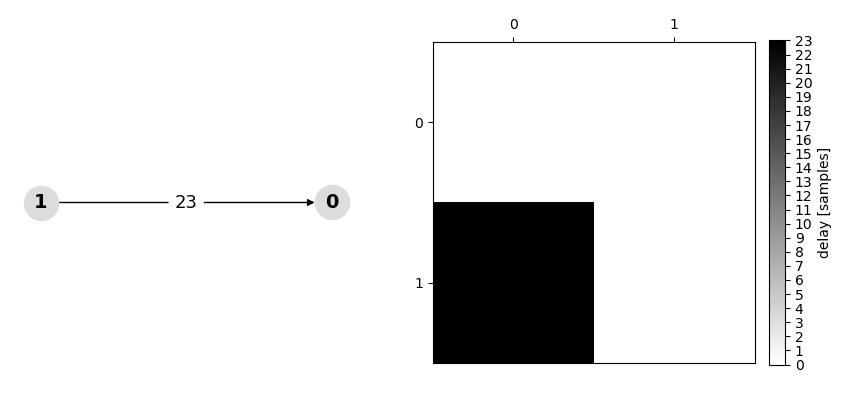

In [ ]:
network_analysis = BivariateTE()
settings = {'cmi_estimator': 'JidtGaussianCMI',
            'max_lag': 24,
            'max_lag_sources': 24,
            'min_lag_sources': 1}

# settings = {'cmi_estimator': 'OpenCLKraskovCMI',
#             'max_lag': 24,
#             'max_lag_sources': 24,
#             'min_lag_sources': 1}



sol_slice = hist_sol.groupby('lat')[lat].groupby('lon')[lon].groupby('time.month')
all_slice = hist_all.groupby('lat')[lat].groupby('lon')[lon].groupby('time.month')
sn_slice = sn.groupby('time.month')
for month in range(1,13):
    dataList = [all_slice[month]['tas'].data, sn_slice[month]['SNav']]
    idt_data = Data(np.column_stack((itertools.zip_longest(*dataList, fillvalue=0))), dim_order='ps')
    results = network_analysis.analyse_network(settings=settings, data=idt_data, sources=[1], targets=[0])

    results.print_edge_list(weights='max_te_lag', fdr=False)
    plot_network(results=results, weights='max_te_lag', fdr=False)

            

In [ ]:
import idtxl.estimators_opencl
help(idtxl.estimators_opencl)

Help on module idtxl.estimators_opencl in idtxl:

NAME
    idtxl.estimators_opencl

CLASSES
    idtxl.estimator.Estimator(builtins.object)
        OpenCLKraskov
            OpenCLKraskovCMI
            OpenCLKraskovMI
    
    class OpenCLKraskov(idtxl.estimator.Estimator)
     |  OpenCLKraskov(settings=None)
     |  
     |  Abstract class for implementation of OpenCL estimators.
     |  
     |  Abstract class for implementation of OpenCL estimators, child classes
     |  implement estimators for mutual information (MI) and conditional mutual
     |  information (CMI) using the Kraskov-Grassberger-Stoegbauer estimator for
     |  continuous data.
     |  
     |  References:
     |  
     |  - Kraskov, A., Stoegbauer, H., & Grassberger, P. (2004). Estimating mutual
     |    information. Phys Rev E, 69(6), 066138.
     |  - Lizier, Joseph T., Mikhail Prokopenko, and Albert Y. Zomaya. (2012).
     |    Local measures of information storage in complex distributed computation.
     |   